<a href="https://colab.research.google.com/github/nradhakrishna/LSTM-vs-TCN/blob/main/lstm_vs_tcn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[LSTM] Epoch 1, Loss: 0.0016
[LSTM] Epoch 2, Loss: 0.0014
[LSTM] Epoch 3, Loss: 0.0013
[LSTM] Epoch 4, Loss: 0.0013
[LSTM] Epoch 5, Loss: 0.0013
[LSTM] Epoch 6, Loss: 0.0013
[LSTM] Epoch 7, Loss: 0.0013
[LSTM] Epoch 8, Loss: 0.0013
[LSTM] Epoch 9, Loss: 0.0013
[LSTM] Epoch 10, Loss: 0.0013
[LSTM] Epoch 11, Loss: 0.0013
[LSTM] Epoch 12, Loss: 0.0013
[LSTM] Epoch 13, Loss: 0.0013
[LSTM] Epoch 14, Loss: 0.0013
[LSTM] Epoch 15, Loss: 0.0013
[LSTM] Epoch 16, Loss: 0.0013
[LSTM] Epoch 17, Loss: 0.0013
[LSTM] Epoch 18, Loss: 0.0013
[LSTM] Epoch 19, Loss: 0.0013
[LSTM] Epoch 20, Loss: 0.0013
[LSTM] Epoch 21, Loss: 0.0013
[LSTM] Epoch 22, Loss: 0.0013
[LSTM] Epoch 23, Loss: 0.0013
[LSTM] Epoch 24, Loss: 0.0013
[LSTM] Epoch 25, Loss: 0.0013
[LSTM] Epoch 26, Loss: 0.0013
[LSTM] Epoch 27, Loss: 0.0013
[LSTM] Epoch 28, Loss: 0.0013
[LSTM] Epoch 29, Loss: 0.0013
[LSTM] Epoch 30, Loss: 0.0013
[LSTM] Epoch 31, Loss: 0.0013
[LSTM] Epoch 32, Loss: 0.0013
[LSTM] Epoch 33, Loss: 0.0013
[LSTM] Epoch 34, Lo

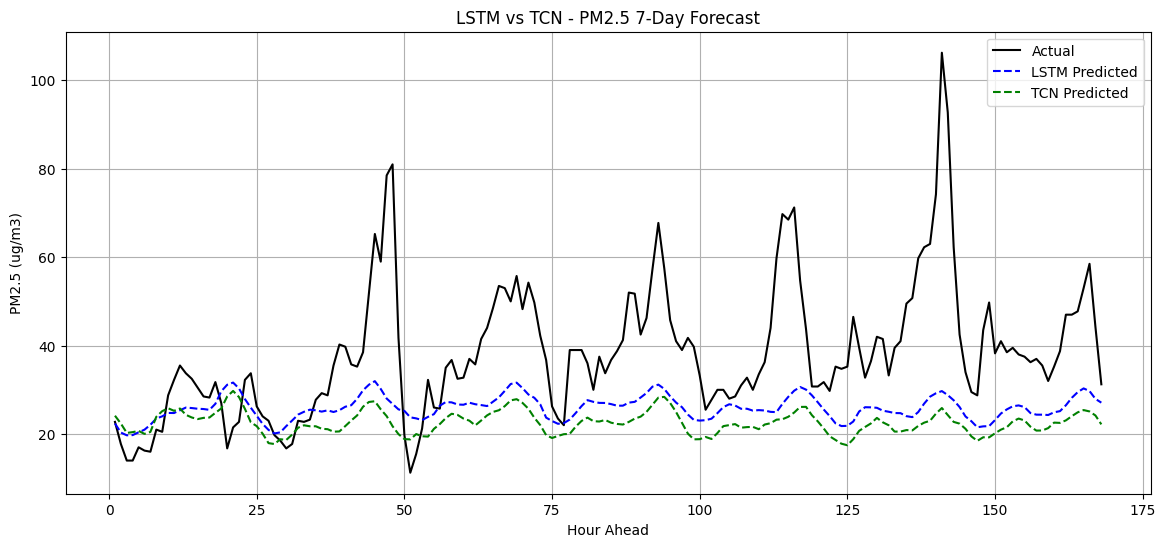

--- Error Metrics (7-Day Forecast) ---
LSTM RMSE: 18.532, MAE: 13.873
TCN  RMSE: 21.248, MAE: 16.751


In [ ]:
  # Full TCN vs LSTM Comparison Code for 7-Day (168-hour) PM2.5 Forecast
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# --- Load and preprocess data ---
data = pd.read_csv("AP001.csv")
data['PM2.5 (ug/m3)'] = data['PM2.5 (ug/m3)'].ffill()
series = data['PM2.5 (ug/m3)'].values.reshape(-1, 1)

scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series)

input_window = 24
forecast_horizon = 168
X, Y = [], []
for i in range(len(series_scaled) - input_window - forecast_horizon):
    X.append(series_scaled[i:i + input_window])
    Y.append(series_scaled[i + input_window:i + input_window + forecast_horizon].flatten())
X, Y = np.array(X), np.array(Y)

X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)
split = int(len(X) * 0.8)
train_dataset = TensorDataset(X_tensor[:split], Y_tensor[:split])
test_dataset = TensorDataset(X_tensor[split:], Y_tensor[split:])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=64, batch_first=True)
        self.fc = nn.Linear(64, forecast_horizon)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)
lstm_model = LSTMModel()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)
s1=time.time()
for epoch in range(50):
    lstm_model.train()
    total_loss = 0
    for xb, yb in train_loader:
        pred = lstm_model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[LSTM] Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")
e1=time.time()
print("LSTM Training Time: ",e1-s1)
# --- Evaluate LSTM ---
lstm_model.eval()
all_preds_lstm, all_true = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        preds = lstm_model(xb)
        all_preds_lstm.append(preds.numpy())
        all_true.append(yb.numpy())
all_preds_lstm = np.concatenate(all_preds_lstm)
all_true = np.concatenate(all_true)

last_pred_lstm = scaler.inverse_transform(all_preds_lstm[-1].reshape(-1, 1))
last_true = scaler.inverse_transform(all_true[-1].reshape(-1, 1))

# --- Define TCN model ---
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size
    def forward(self, x):
        return x[:, :, :-self.chomp_size]
class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding):
        super().__init__()
        self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size, stride, padding, dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size, stride, padding, dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.conv2, self.chomp2, self.relu2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return out + res
class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size=2):
        super().__init__()
        layers = []
        for i in range(len(num_channels)):
            dilation = 2 ** i
            in_channels = input_size if i == 0 else num_channels[i - 1]
            out_channels = num_channels[i]
            layers.append(TemporalBlock(in_channels, out_channels, kernel_size, 1, dilation, (kernel_size - 1) * dilation))
        self.network = nn.Sequential(*layers)
        self.linear = nn.Linear(num_channels[-1] * input_window, output_size)
    def forward(self, x):
        x = x.transpose(1, 2)
        y = self.network(x)
        y = y.flatten(start_dim=1)
        return self.linear(y)
# --- Train TCN ---
tcn_model = TCN(input_size=1, output_size=forecast_horizon, num_channels=[32, 32, 32])
optimizer = torch.optim.Adam(tcn_model.parameters(), lr=0.001)
s2=time.time()
for epoch in range(50):
    tcn_model.train()
    total_loss = 0
    for xb, yb in train_loader:
        pred = tcn_model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[TCN] Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")
e2=time.time()
print("TCN Training Time: ",e2-s2)
# --- Evaluate TCN ---
tcn_model.eval()
all_preds_tcn = []
with torch.no_grad():
    for xb, yb in test_loader:
        preds = tcn_model(xb)
        all_preds_tcn.append(preds.numpy())
all_preds_tcn = np.concatenate(all_preds_tcn)
last_pred_tcn = scaler.inverse_transform(all_preds_tcn[-1].reshape(-1, 1))

# --- Compare and Plot ---
rmse = lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))
mae = lambda y_true, y_pred: mean_absolute_error(y_true, y_pred)

plt.figure(figsize=(14, 6))
plt.plot(range(1, 169), last_true, label='Actual', color='black')
plt.plot(range(1, 169), last_pred_lstm, label='LSTM Predicted', linestyle='--', color='blue')
plt.plot(range(1, 169), last_pred_tcn, label='TCN Predicted', linestyle='--', color='green')
plt.title("LSTM vs TCN - PM2.5 7-Day Forecast")
plt.xlabel("Hour Ahead")
plt.ylabel("PM2.5 (ug/m3)")
plt.legend()
plt.grid(True)
plt.show()

print("--- Error Metrics (7-Day Forecast) ---")
print(f"LSTM RMSE: {rmse(last_true, last_pred_lstm):.3f}, MAE: {mae(last_true, last_pred_lstm):.3f}")
print(f"TCN  RMSE: {rmse(last_true, last_pred_tcn):.3f}, MAE: {mae(last_true, last_pred_tcn):.3f}")


In [ ]:
print("TCN Training Time: ",e1-s1)
print("LSTM Training Time: ",e2-s2)

NameError: name 'e1' is not defined

In [ ]:
import requests

# --- Notification Setup ---
API_KEY = "axvc751kychdzeisp2fei1aqs6kxss"
APP_ID = "upnq1kzo1euijd11nr4crani1g26qm"
DANGER_THRESHOLD = 20  # µg/m³

def send_alert_notification(max_pm25, hour):
    message = f"⚠️ PM2.5 will reach {max_pm25:.1f} µg/m³ at hour {hour}. Take precautions!"
    url = "https://api.pushover.net/1/messages.json"
    payload = {
        "token": API_KEY,
        "user": APP_ID,
        "title": "Air Quality Alert 🚨",
        "message": message,
        "priority": 1
    }
    response = requests.post(url, data=payload)
    if response.status_code == 200:
        print("✅ Pushover notification sent.")
    else:
        print(f"❌ Failed to send alert. Status: {response.status_code}, Response: {response.text}")
# --- Example: Trigger after getting predictions ---
def check_and_notify(predicted_values_scaled, scaler):
    predicted_values = scaler.inverse_transform(predicted_values_scaled.reshape(-1, 1)).flatten()
    max_val = predicted_values.max()
    max_hour = predicted_values.argmax() + 1  # +1 to match hour indexing from 1 to 168

    if max_val >= DANGER_THRESHOLD:
        send_alert_notification(max_val, max_hour)
    else:
        print("✅ Air quality forecast is within safe limits.")

# --- Usage after getting model prediction ---
check_and_notify(all_preds_tcn[-1], scaler)
# or use: check_and_notify(all_preds_lstm[-1], scaler)

NameError: name 'all_preds_tcn' is not defined

In [ ]:
print("hello world")

hello world
